This notebook attempts to use only top 25 important factors


In [124]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
from IPython.core.pylabtools import figsize
from scipy.stats import bernoulli

MSH = os.getenv('MSH')

import sys
sys.path.append('{0}/../'.format(MSH))

from common_libs.db_conn import DBConn
from MSH.model import ChurnModel  # My Random Forest model
from lifelines import CoxPHFitter, KaplanMeierFitter, AalenAdditiveFitter
from lifelines.utils import k_fold_cross_validation
from sklearn.preprocessing import StandardScaler

# get rid of pesky pandas warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.style.use('ggplot')

In [3]:
# load a pre-fitted Random Forest model & load the already processed data

model = ChurnModel('clean.customer_attributes_clipped')
model.load_saved_model('output/model.pkl')
_ = model._custom_preprocessing()


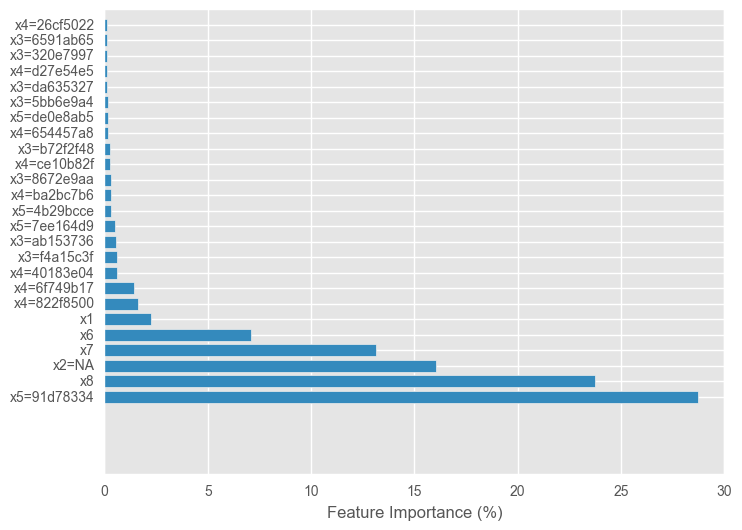

In [6]:
# find the top 25 most important features to the fit

figsize(8, 6)
top25_idx = np.argsort(-model.model.named_steps['random_forest'].feature_importances_)[:25]
top25_values = model.model.named_steps['random_forest'].feature_importances_[top25_idx] * 100

data = model.data_processed
data.rename(columns=lambda x: x.replace('<NA>', 'NA'), inplace=True)  # <> symbols break patsy.dmatrix()


top25_labels = data.columns[top25_idx].tolist()
top25_labels_pretty = [x.replace('_', '=') for x in top25_labels]  # clean up the feature name

# plot relative importance of each feature
plt.clf()

N_features = len(top25_idx)
y = range(N_features)

plt.barh(y, top25_values, tick_label=top25_labels_pretty, align='center')
plt.xlabel('Feature Importance (%)')

In [9]:
# 1.  construct the design matrix from the top 25 most important features
# 2.  perform pre-processing steps (mean subtract + STDDEV normalize)
# 3.  Add labels

# fill missing values with mean value
numerical_cols = [x for x in top25_labels if '_' not in x]
cat_cols = [x for x in top25_labels if '_' in x]

fill_dict = {
    name: data[name].mean() for name in numerical_cols
}

data.fillna(value=fill_dict, inplace=True)

X = patsy.dmatrix(' + '.join(top25_labels) + '- 1', data, return_type='dataframe')

# feature scaling on numerical features
scaler = StandardScaler()

numerical_data = X[numerical_cols]
X_num = scaler.fit_transform(numerical_data)

numerical_data_trans = pd.DataFrame(X_num, index=numerical_data.index, columns=numerical_cols)
X.update(numerical_data_trans)

# add duration + censorship labels
X['duration'] = model.data.days_since_signup
X['observed'] = model.data.status.apply(lambda x: 1 if x == 'canceled' else 0)


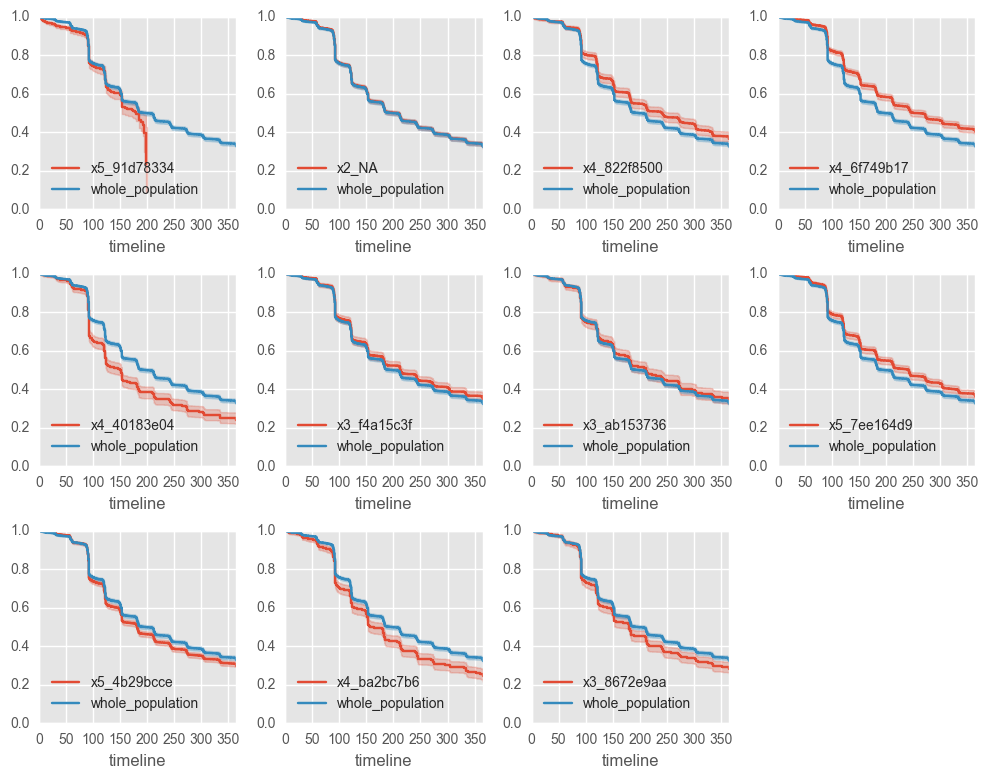

In [12]:
# Plot survival curves for the categorical features in the top 10 list


kmf= KaplanMeierFitter()
figsize(10, 10)

i = 0
for col in top25_labels[:15]:
    if col in cat_cols:
        ax = plt.subplot(4, 4, i + 1)
        subset = X.loc[X[col] == 1]
        kmf.fit(subset['duration'], subset['observed'], label=col)
        kmf.plot(ax=ax)
        kmf.fit(X['duration'], X['observed'], label='whole_population')
        kmf.plot(ax=ax)
        plt.xlim([0, 365])
        plt.ylim([0, 1])
        i += 1
    
plt.tight_layout()
    

 - *x5_91d78334* has a significantly higher hazard function than the population
 - *x2 = NA* has little difference from baseline hazard, probably because it correlates very closely with it.  This may be why it's a top feature from the RF model

In [44]:
def fit_cox_model(X, N=10):
    # use CV to find the optimal value for regularization
    
    reg_params = np.logspace(-1, 2, num=N)
    
    cv_scores = np.zeros(N)
    for i, p in enumerate(reg_params):
        print('Fitting model {0} of {1}'.format(i + 1, N))
        cox = CoxPHFitter(penalizer=p, normalize=False)
        scores = k_fold_cross_validation(cox, X, 'duration', 'observed', k=5)
        cv_scores[i] = np.mean(scores)
        
    best_model_idx = np.argmax(cv_scores)    
    print('Best model has mean concordance of {0}, using penalizer {1}'\
          .format(cv_scores[best_model_idx], reg_params[best_model_idx]
    ))
    
    best_model = CoxPHFitter(penalizer=reg_params[best_model_idx], normalize=False)
    best_model.fit(X, 'duration', 'observed')
    
    return best_model
        

In [47]:
cox_model = fit_cox_model(X)

Fitting model 1 of 10
Fitting model 2 of 10
Fitting model 3 of 10
Fitting model 4 of 10
Fitting model 5 of 10
Fitting model 6 of 10
Fitting model 7 of 10
Fitting model 8 of 10
Fitting model 9 of 10
Fitting model 10 of 10
Best model has mean concordance of 0.5927147267401685, using penalizer 0.46415888336127786


In [49]:
cox_model.print_summary()

n=9751, number of events=6431

                  coef  exp(coef)  se(coef)          z         p  lower 0.95  upper 0.95     
x5_91d78334  4.614e-01  1.586e+00 9.701e-02  4.756e+00 1.975e-06   2.712e-01   6.515e-01  ***
x8          -1.377e-02  9.863e-01 1.271e-02 -1.084e+00 2.785e-01  -3.869e-02   1.114e-02     
x2_NA        1.618e-02  1.016e+00 7.770e-02  2.082e-01 8.350e-01  -1.361e-01   1.685e-01     
x7          -8.980e-02  9.141e-01 1.633e-02 -5.497e+00 3.853e-08  -1.218e-01  -5.778e-02  ***
x6          -5.604e-02  9.455e-01 1.572e-02 -3.566e+00 3.628e-04  -8.685e-02  -2.523e-02  ***
x1          -1.599e-02  9.841e-01 1.623e-02 -9.851e-01 3.246e-01  -4.780e-02   1.583e-02     
x4_822f8500 -1.199e-01  8.870e-01 6.726e-02 -1.783e+00 7.465e-02  -2.518e-01   1.196e-02    .
x4_6f749b17 -1.889e-01  8.278e-01 6.393e-02 -2.955e+00 3.125e-03  -3.143e-01  -6.360e-02   **
x4_40183e04  2.921e-01  1.339e+00 6.964e-02  4.195e+00 2.733e-05   1.556e-01   4.286e-01  ***
x3_f4a15c3f -9.212e-02  9.120

In [131]:
# sync up individual customers' survival curves with current date (Jan 14, 2016) and project forward

preds = cox_model.predict_survival_function(X)

# re-index and interpolate between known durations
n_days_max = 3000

preds = preds.reindex(index=np.arange(n_days_max))
preds.interpolate(method='linear', inplace=True)

# predict current customer's churn at T + 90 days
current_users = model.data[model.data.status == 'active']

t_predict = 90

for uid, row in current_users.iterrows():
    current_users.loc[uid, 'S(t=90)'] = preds.loc[t_predict + row.days_since_signup, uid]
    current_users.loc[uid, 'S(t=0)'] = preds.loc[row.days_since_signup, uid]

current_users['P_churn(t=90)'] = current_users['S(t=0)'] - current_users['S(t=90)']


expected number of customers that will churn is 512.988
95% credibility interval is (476.0, 551.0)


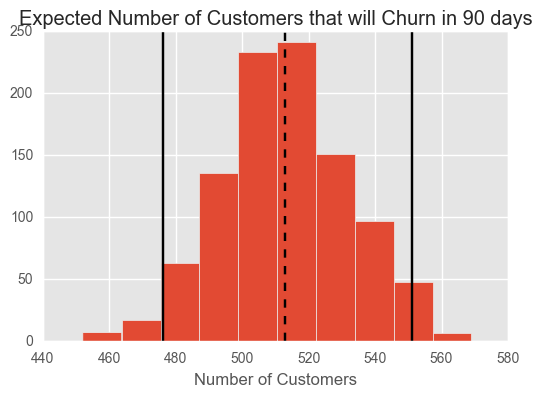

In [123]:
# Now that we have P(Churn) for N customers, simulate the results of N Bernoulli trials (with varying p)
# Since p is different for each customer, this is not a Binomial Distribution, it's a Poisson Binomial.  
# Let's simulate it 

n_realizations = 1000
n_users = len(current_users)

sims = np.zeros((n_users, n_realizations))
for i, (uid, row) in enumerate(current_users.iterrows()):
    sims[i, :] = bernoulli.rvs(p=row['P_churn(t=90)'], size=n_realizations)

expected_number_of_churns = sims.mean(axis=1).sum()
churn_dist = sims.sum(axis=0)
plt.hist(churn_dist)

s = np.sort(churn_dist)
lower_bound = s[int(.025 * n_realizations)]
upper_bound = s[int(.975 * n_realizations)]

print('expected number of customers that will churn is {0}'.format(expected_number_of_churns))
print('95% credibility interval is ({0}, {1})'.format(lower_bound, upper_bound))

ax = plt.gca()
ymin, ymax = ax.get_ylim()
ax.vlines(lower_bound, ymin, ymax)
ax.vlines(upper_bound, ymin, ymax)

ax.vlines(expected_number_of_churns, ymin, ymax, linestyles='dashed')
ax.set_title('Expected Number of Customers that will Churn in 90 days')
ax.set_xlabel('Number of Customers')


In [130]:
# 100 customers most at risk of churning in 90 days
current_users.sort_values('P_churn(t=90)', ascending=False)[:100]

,signup_date,status,cancel_date,days_since_signup,x1,x2,x3,x4,x5,x6,x7,x8,S(t=90),S(t=0),P_churn(t=90)
customer_id,,,,,,,,,,,,,,,
b41b3bf3-2b04-43b6-b443-e22130e17162,2015-11-11,active,NaT,66,1.00,416e1394,b72f2f48,ce10b82f,91d78334,1.68,0.30,0.17,0.299016,0.878642,0.579625
0d99d436-b70e-4dc2-9c7b-efb7c0b930da,2015-11-13,active,NaT,64,1.33,416e1394,b72f2f48,ce10b82f,91d78334,0.00,0.00,0.08,0.302527,0.879133,0.576606
cb1440be-b651-41fb-a829-29db442a68da,2015-10-29,active,NaT,79,1.33,416e1394,8672e9aa,ce10b82f,91d78334,0.71,1.42,0.42,0.314609,0.873274,0.558665
1cfa29c2-d474-4a86-9ff7-dc34767a52c0,2015-10-30,active,NaT,78,1.00,fd76e8b1,31e28e8f,ce10b82f,91d78334,0.11,0.07,0.08,0.330009,0.879159,0.549150
d999672c-08b5-44c5-8983-e2feebcf857d,2015-12-07,active,NaT,40,1.00,416e1394,8672e9aa,ce10b82f,91d78334,0.11,0.05,0.33,0.401747,0.948059,0.546312
471ca2ab-741a-4f93-88fa-80de734a076a,2015-10-29,active,NaT,79,1.00,416e1394,5bb6e9a4,ce10b82f,91d78334,0.90,1.25,0.00,0.334370,0.879530,0.545159
f21c2f1d-5b55-4206-b8be-d4294093c52a,2015-11-12,active,NaT,65,1.00,416e1394,1bd0be8a,ce10b82f,91d78334,1.83,0.59,0.17,0.348299,0.892853,0.544554
1dba4ca0-f8fc-4f49-b43a-aee7ea3b1a73,2015-10-27,active,NaT,81,1.33,416e1394,0c78d5e6,ce10b82f,91d78334,0.38,0.41,0.50,0.340424,0.880614,0.540190
f4d2a8ff-b368-4f87-9a98-62ac4516798d,2015-11-02,active,NaT,75,1.33,416e1394,0c6fdf98,ce10b82f,91d78334,1.65,0.67,0.42,0.349898,0.888972,0.539074
